<a href="https://colab.research.google.com/github/mvoassis/churn_detection/blob/main/notebooks/Churn_prediction_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [138]:
import pandas as pd
import json
import requests

## Loading Data from API data (JSON format)

In [139]:
url = 'https://challenge-data-science-3ed.s3.amazonaws.com/Telco-Customer-Churn.json'

response = requests.get(url)

data = response.json()

data = pd.json_normalize(data)
data.head()

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,internet.OnlineSecurity,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


## Data cleaning process



In [140]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechSupport       7267 non-null   objec

> 7267 entries, none of them are Nulls.

> Only 3 numeric features? It seems strange. Let's fix the dataset before proceeding to the EDA.

In [141]:
# Checking numeric features

for col in data.select_dtypes(exclude='object').columns:
  print(col)
  print(data[col].unique())
  print()

customer.SeniorCitizen
[0 1]

customer.tenure
[ 9  4 13  3 71 63  7 65 54 72  5 56 34  1 45 50 23 55 26 69 11 37 49 66
 67 20 43 59 12 27  2 25 29 14 35 64 39 40  6 30 70 57 58 16 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 51 31 36 17 18 38 42
  0]

account.Charges.Monthly
[65.6  59.9  73.9  ... 91.75 68.8  67.85]



In [142]:
# Checking object features:

for col in data.select_dtypes(include='object').columns:
  print(col)
  print(data[col].unique())
  print()

customerID
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']

Churn
['No' 'Yes' '']

customer.gender
['Female' 'Male']

customer.Partner
['Yes' 'No']

customer.Dependents
['Yes' 'No']

phone.PhoneService
['Yes' 'No']

phone.MultipleLines
['No' 'Yes' 'No phone service']

internet.InternetService
['DSL' 'Fiber optic' 'No']

internet.OnlineSecurity
['No' 'Yes' 'No internet service']

internet.OnlineBackup
['Yes' 'No' 'No internet service']

internet.DeviceProtection
['No' 'Yes' 'No internet service']

internet.TechSupport
['Yes' 'No' 'No internet service']

internet.StreamingTV
['Yes' 'No' 'No internet service']

internet.StreamingMovies
['No' 'Yes' 'No internet service']

account.Contract
['One year' 'Month-to-month' 'Two year']

account.PaperlessBilling
['Yes' 'No']

account.PaymentMethod
['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']

account.Charges.Total
['593.3' '542.4' '280.85' ... '742.9' '4627.65' '370

> **Features to fix:**

1. customerID is useless to a prediction method, should be droped.

2. phone.MultipleLines, internet.OnlineSecurity, internet.OnlineBackup, internet.DeviceProtection, internet.TechSupport, internet.StreamingTV, internet.StreamingMovies: have "No XXX service" values, which maybe could be translated by "No".

3. internet.InternetService, account.Contract, account.PaymentMethod: apply one-hot encoding.

4. account.Charges.Total: convert to float

5. Churn have '' values, that can be used on validation afterwards. Need to be removed from training.

6. Churn, customer.gender, customer.Partner, customer.Dependents, phone.PhoneService, phone.MultipleLines, internet.OnlineSecurity, internet.OnlineBackup, internet.DeviceProtection, internet.TechSupport, internet.StreamingTV, internet.StreamingMovies,account.PaperlessBilling: convert to numeric binary using map().

7. Normalize feature names.




---



### Fixing 1: customerID is useless to a prediction method, should be droped.


In [143]:
data = data.drop('customerID', axis=1)
data.head()

,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,internet.OnlineSecurity,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


### Fixing 2: phone.MultipleLines, internet.OnlineSecurity, internet.OnlineBackup, internet.DeviceProtection, internet.TechSupport, internet.StreamingTV, internet.StreamingMovies: have "No XXX service" values, which maybe could be translated by "No".

In [144]:
data['phone.MultipleLines'].value_counts()

No                  3495
Yes                 3065
No phone service     707
Name: phone.MultipleLines, dtype: int64

In [145]:
fix_MultipleLines = {'No': 'No',
                     'Yes': 'Yes',
                     'No phone service': 'No'}

data['phone.MultipleLines'] = data['phone.MultipleLines'].map(fix_MultipleLines)

data['phone.MultipleLines'].value_counts()

No     4202
Yes    3065
Name: phone.MultipleLines, dtype: int64

In [146]:
data['internet.OnlineBackup'].value_counts()

No                     3182
Yes                    2504
No internet service    1581
Name: internet.OnlineBackup, dtype: int64

In [147]:
internet_related = ['internet.OnlineSecurity', 'internet.OnlineBackup',
                    'internet.DeviceProtection', 'internet.TechSupport',
                    'internet.StreamingTV', 'internet.StreamingMovies']

fix_internet_related = {'No': 'No',
                        'Yes': 'Yes',
                        'No internet service': 'No'}

for feature in internet_related:
  print(data[feature].value_counts(), end='\n\n')

  data[feature] = data[feature].map(fix_internet_related)

  print(data[feature].value_counts(), end='\n---------------------------\n')



No                     3608
Yes                    2078
No internet service    1581
Name: internet.OnlineSecurity, dtype: int64

No     5189
Yes    2078
Name: internet.OnlineSecurity, dtype: int64
---------------------------
No                     3182
Yes                    2504
No internet service    1581
Name: internet.OnlineBackup, dtype: int64

No     4763
Yes    2504
Name: internet.OnlineBackup, dtype: int64
---------------------------
No                     3195
Yes                    2491
No internet service    1581
Name: internet.DeviceProtection, dtype: int64

No     4776
Yes    2491
Name: internet.DeviceProtection, dtype: int64
---------------------------
No                     3582
Yes                    2104
No internet service    1581
Name: internet.TechSupport, dtype: int64

No     5163
Yes    2104
Name: internet.TechSupport, dtype: int64
---------------------------
No                     2896
Yes                    2790
No internet service    1581
Name: internet.Streami

### Fixing 3: internet.InternetService, account.Contract, account.PaymentMethod: apply one-hot encoding

In [148]:
from sklearn.preprocessing import OneHotEncoder

ohe_fix_list = ['internet.InternetService', 'account.Contract', 'account.PaymentMethod']

for feature in ohe_fix_list:
  ohe = OneHotEncoder()

  encoded_feature = ohe.fit_transform(data[[feature]])

  encoded_df = pd.DataFrame(encoded_feature.toarray(), columns=ohe.get_feature_names_out([feature]))

  data = pd.concat([data, encoded_df], axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 30 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Churn                                            7267 non-null   object 
 1   customer.gender                                  7267 non-null   object 
 2   customer.SeniorCitizen                           7267 non-null   int64  
 3   customer.Partner                                 7267 non-null   object 
 4   customer.Dependents                              7267 non-null   object 
 5   customer.tenure                                  7267 non-null   int64  
 6   phone.PhoneService                               7267 non-null   object 
 7   phone.MultipleLines                              7267 non-null   object 
 8   internet.InternetService                         7267 non-null   object 
 9   internet.OnlineSecurity       

In [149]:
# dropping the initial features

data = data.drop(['internet.InternetService', 'account.Contract', 'account.PaymentMethod'], axis=1)

### Fixing 4: account.Charges.Total: convert to float


In [150]:
pd.get_option('display.max_columns')

In [151]:
pd.set_option('display.max_columns', None)

In [152]:
data[data['account.Charges.Total']==" "]

,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.OnlineSecurity,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.PaperlessBilling,account.Charges.Monthly,account.Charges.Total,internet.InternetService_DSL,internet.InternetService_Fiber optic,internet.InternetService_No,account.Contract_Month-to-month,account.Contract_One year,account.Contract_Two year,account.PaymentMethod_Bank transfer (automatic),account.PaymentMethod_Credit card (automatic),account.PaymentMethod_Electronic check,account.PaymentMethod_Mailed check
975,No,Female,0,Yes,Yes,0,No,No,Yes,Yes,Yes,Yes,Yes,No,No,56.05,,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1775,No,Female,0,Yes,Yes,0,Yes,No,No,No,No,No,No,No,No,20.00,,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1955,No,Male,0,No,Yes,0,Yes,Yes,Yes,Yes,No,Yes,No,No,Yes,61.90,,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2075,No,Male,0,Yes,Yes,0,Yes,No,No,No,No,No,No,No,Yes,19.70,,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2232,No,Male,0,No,Yes,0,Yes,No,No,No,No,No,No,No,No,20.25,,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2308,No,Male,0,Yes,Yes,0,Yes,Yes,No,No,No,No,No,No,No,25.35,,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2930,No,Female,0,Yes,Yes,0,Yes,Yes,No,Yes,Yes,Yes,Yes,No,No,73.35,,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3134,No,Male,0,Yes,Yes,0,Yes,Yes,No,No,No,No,No,No,No,25.75,,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3203,No,Female,0,Yes,Yes,0,No,No,Yes,No,Yes,Yes,Yes,No,Yes,52.55,,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4169,No,Female,0,Yes,Yes,0,Yes,No,Yes,Yes,Yes,No,Yes,Yes,No,80.85,,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [153]:
data[data['account.Charges.Total']==" "]['Churn'].count()

11

There are 11 empty lines. Since all of them represents clients without churn, it is not feasible to substitute them to 0. I'll drop them by now, but fill them using the data distributions also could be a good strategy.

In [154]:
data = data[data['account.Charges.Total']!=" "].copy()

Now, proceeding with the conversion...

In [155]:
data['account.Charges.Total'] = data['account.Charges.Total'].astype(float)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7256 entries, 0 to 7266
Data columns (total 27 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Churn                                            7256 non-null   object 
 1   customer.gender                                  7256 non-null   object 
 2   customer.SeniorCitizen                           7256 non-null   int64  
 3   customer.Partner                                 7256 non-null   object 
 4   customer.Dependents                              7256 non-null   object 
 5   customer.tenure                                  7256 non-null   int64  
 6   phone.PhoneService                               7256 non-null   object 
 7   phone.MultipleLines                              7256 non-null   object 
 8   internet.OnlineSecurity                          7256 non-null   object 
 9   internet.OnlineBackup         

### Fixing 5: Churn have **''** values, that can be used on validation afterwards. Need to be removed from training.

In [156]:
data_val = data[data['Churn']==''].copy()

In [157]:
data = data[data['Churn']!=''].copy()

### Fixing 6: Churn, customer.gender, customer.Partner, customer.Dependents, phone.PhoneService, phone.MultipleLines, internet.OnlineSecurity, internet.OnlineBackup, internet.DeviceProtection, internet.TechSupport, internet.StreamingTV, internet.StreamingMovies,account.PaperlessBilling: convert to numeric binary using map().

In [158]:
fix_gender = { 'Male': 1,
               'Female' : 0 }

data['customer.gender'] = data['customer.gender'].map(fix_gender)

In [159]:
fix_yes_no = { 'Yes': 1,
               'No' : 0 }

fixlist_yes_no = ['Churn', 'customer.Partner', 'customer.Dependents', 'phone.PhoneService',
                  'phone.MultipleLines', 'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection',
                  'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies', 'account.PaperlessBilling' ]

for feature in fixlist_yes_no:
  data[feature] = data[feature].map(fix_yes_no)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7266
Data columns (total 27 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Churn                                            7032 non-null   int64  
 1   customer.gender                                  7032 non-null   int64  
 2   customer.SeniorCitizen                           7032 non-null   int64  
 3   customer.Partner                                 7032 non-null   int64  
 4   customer.Dependents                              7032 non-null   int64  
 5   customer.tenure                                  7032 non-null   int64  
 6   phone.PhoneService                               7032 non-null   int64  
 7   phone.MultipleLines                              7032 non-null   int64  
 8   internet.OnlineSecurity                          7032 non-null   int64  
 9   internet.OnlineBackup         

### Fixing 7: Normalize feature names.

In [165]:
new_names = []
for column in data.columns:
  new_names.append(column.replace('.', '_').replace(' ','_').replace('-','_').replace('_(automatic)',''))

data.columns = new_names
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7266
Data columns (total 27 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Churn                                   7032 non-null   int64  
 1   customer_gender                         7032 non-null   int64  
 2   customer_SeniorCitizen                  7032 non-null   int64  
 3   customer_Partner                        7032 non-null   int64  
 4   customer_Dependents                     7032 non-null   int64  
 5   customer_tenure                         7032 non-null   int64  
 6   phone_PhoneService                      7032 non-null   int64  
 7   phone_MultipleLines                     7032 non-null   int64  
 8   internet_OnlineSecurity                 7032 non-null   int64  
 9   internet_OnlineBackup                   7032 non-null   int64  
 10  internet_DeviceProtection               7032 non-null   int6

## Extensive Data Analysis (EDA)

### Basic evaluations

In [166]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7266
Data columns (total 27 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Churn                                   7032 non-null   int64  
 1   customer_gender                         7032 non-null   int64  
 2   customer_SeniorCitizen                  7032 non-null   int64  
 3   customer_Partner                        7032 non-null   int64  
 4   customer_Dependents                     7032 non-null   int64  
 5   customer_tenure                         7032 non-null   int64  
 6   phone_PhoneService                      7032 non-null   int64  
 7   phone_MultipleLines                     7032 non-null   int64  
 8   internet_OnlineSecurity                 7032 non-null   int64  
 9   internet_OnlineBackup                   7032 non-null   int64  
 10  internet_DeviceProtection               7032 non-null   int6

In [167]:
data.describe()

,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_PaperlessBilling,account_Charges_Monthly,account_Charges_Total,internet_InternetService_DSL,internet_InternetService_Fiber_optic,internet_InternetService_No,account_Contract_Month_to_month,account_Contract_One_year,account_Contract_Two_year,account_PaymentMethod_Bank_transfer,account_PaymentMethod_Credit_card,account_PaymentMethod_Electronic_check,account_PaymentMethod_Mailed_check
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.265785,0.504693,0.162400,0.482509,0.298493,32.421786,0.903299,0.421928,0.286547,0.344852,0.343857,0.290102,0.384386,0.388367,0.592719,64.798208,2283.300441,0.343572,0.440273,0.216155,0.551052,0.209329,0.239619,0.219283,0.216297,0.336320,0.228100
std,0.441782,0.500014,0.368844,0.499729,0.457629,24.545260,0.295571,0.493902,0.452180,0.475354,0.475028,0.453842,0.486484,0.487414,0.491363,30.085974,2266.771362,0.474934,0.496455,0.411650,0.497422,0.406858,0.426881,0.413790,0.411748,0.472483,0.419637
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.587500,401.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,70.350000,1397.475000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.862500,3794.737500,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,118.750000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


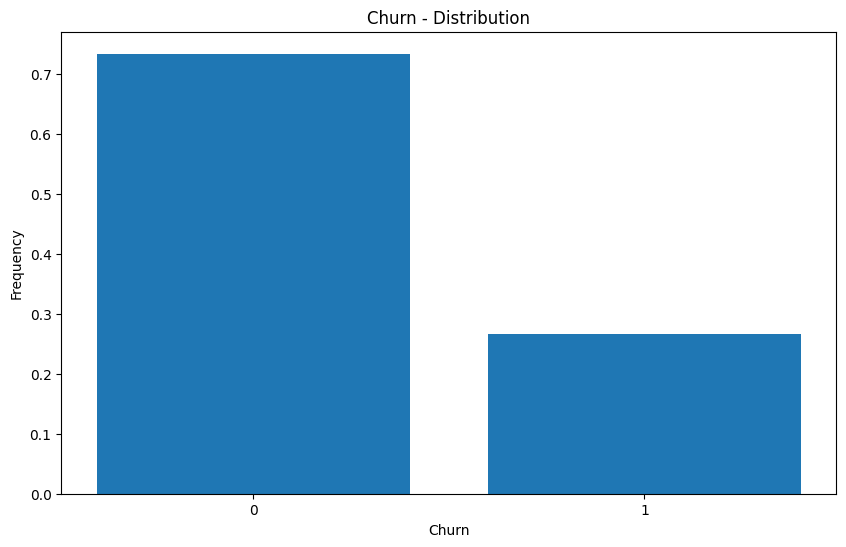

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns

# Explorar distribuição da variável alvo
plt.figure(figsize=(10, 6))
plt.bar(data['Churn'].value_counts(normalize=True).index,data['Churn'].value_counts(normalize=True).values)
plt.title('Churn - Distribution')
plt.xlabel('Churn')
plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.ylabel('Frequency')
plt.show()

### Correlation matrix

1. Evaluate correlation between features and target
2. Evaluate correlation between dependent variables

In [ ]:
!pip install biokit

In [187]:
correlation_matrix = data.corr()
correlation_matrix['Churn'].sort_values(ascending=False)

Churn                                     1.000000
account_Contract_Month_to_month           0.404565
internet_InternetService_Fiber_optic      0.307463
account_PaymentMethod_Electronic_check    0.301455
account_Charges_Monthly                   0.192858
account_PaperlessBilling                  0.191454
customer_SeniorCitizen                    0.150541
internet_StreamingTV                      0.063254
internet_StreamingMovies                  0.060860
phone_MultipleLines                       0.040033
phone_PhoneService                        0.011691
customer_gender                          -0.008545
internet_DeviceProtection                -0.066193
internet_OnlineBackup                    -0.082307
account_PaymentMethod_Mailed_check       -0.090773
account_PaymentMethod_Bank_transfer      -0.118136
internet_InternetService_DSL             -0.124141
account_PaymentMethod_Credit_card        -0.134687
customer_Partner                         -0.149982
customer_Dependents            

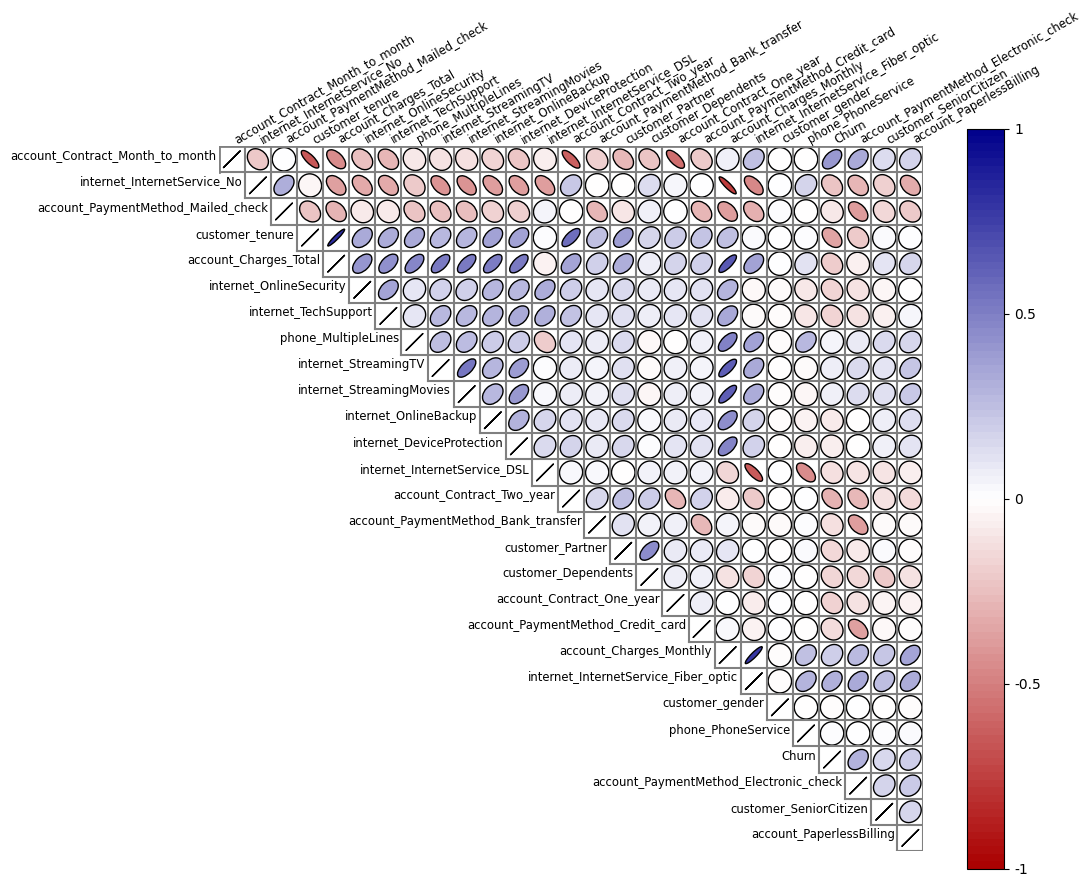

In [202]:
from biokit.viz import corrplot

# correlation_matrix = train_data.drop(['material_5',
#                                       'material_6',
#                                       'measurement_17',
#                                       'measurement_0',
#                                       'attribute_2',
#                                       'attribute_3'],axis=1).corr()

corr_graph = corrplot.Corrplot(correlation_matrix)
corr_graph.plot(upper = 'ellipse', fontsize='small')
fig = plt.gcf()
fig.set_size_inches(20,15)
fig.show()

> Multicollinearity was detected in come of the features. However, as I intend to apply tree based methods to generate the prediction, I'll keep them on the dataset.

### Boxplot of the non binary features

In [197]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7266
Data columns (total 27 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Churn                                   7032 non-null   int64  
 1   customer_gender                         7032 non-null   int64  
 2   customer_SeniorCitizen                  7032 non-null   int64  
 3   customer_Partner                        7032 non-null   int64  
 4   customer_Dependents                     7032 non-null   int64  
 5   customer_tenure                         7032 non-null   int64  
 6   phone_PhoneService                      7032 non-null   int64  
 7   phone_MultipleLines                     7032 non-null   int64  
 8   internet_OnlineSecurity                 7032 non-null   int64  
 9   internet_OnlineBackup                   7032 non-null   int64  
 10  internet_DeviceProtection               7032 non-null   int6

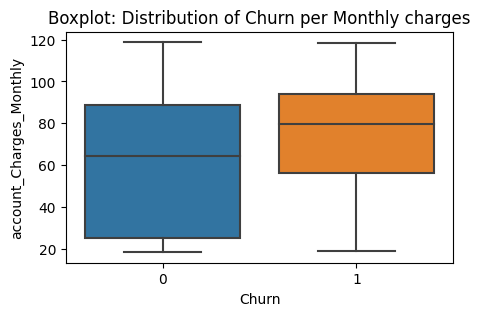

In [195]:
plt.figure(figsize=(5, 3))
sns.boxplot(data=data, x='Churn', y='account_Charges_Monthly')
plt.title('Boxplot: Distribution of Churn per Monthly charges')
plt.show()

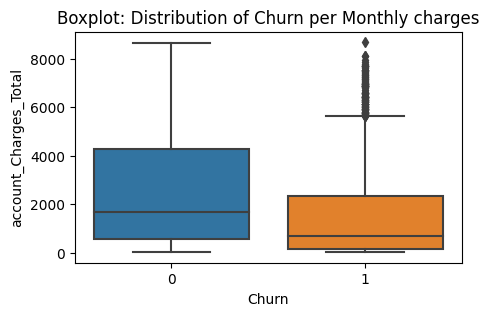

In [196]:
plt.figure(figsize=(5, 3))
sns.boxplot(data=data, x='Churn', y='account_Charges_Total')
plt.title('Boxplot: Distribution of Churn per Monthly charges')
plt.show()

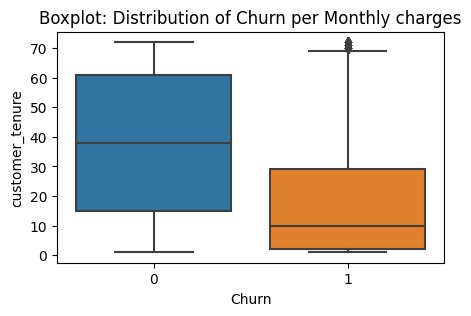

In [203]:
plt.figure(figsize=(5, 3))
sns.boxplot(data=data, x='Churn', y='customer_tenure')
plt.title('Boxplot: Distribution of Churn per Monthly charges')
plt.show()

### Pairplots

* Visual comparison between target variable and the remaining features.

In [198]:
data.columns

Index(['Churn', 'customer_gender', 'customer_SeniorCitizen',
       'customer_Partner', 'customer_Dependents', 'customer_tenure',
       'phone_PhoneService', 'phone_MultipleLines', 'internet_OnlineSecurity',
       'internet_OnlineBackup', 'internet_DeviceProtection',
       'internet_TechSupport', 'internet_StreamingTV',
       'internet_StreamingMovies', 'account_PaperlessBilling',
       'account_Charges_Monthly', 'account_Charges_Total',
       'internet_InternetService_DSL', 'internet_InternetService_Fiber_optic',
       'internet_InternetService_No', 'account_Contract_Month_to_month',
       'account_Contract_One_year', 'account_Contract_Two_year',
       'account_PaymentMethod_Bank_transfer',
       'account_PaymentMethod_Credit_card',
       'account_PaymentMethod_Electronic_check',
       'account_PaymentMethod_Mailed_check'],
      dtype='object')

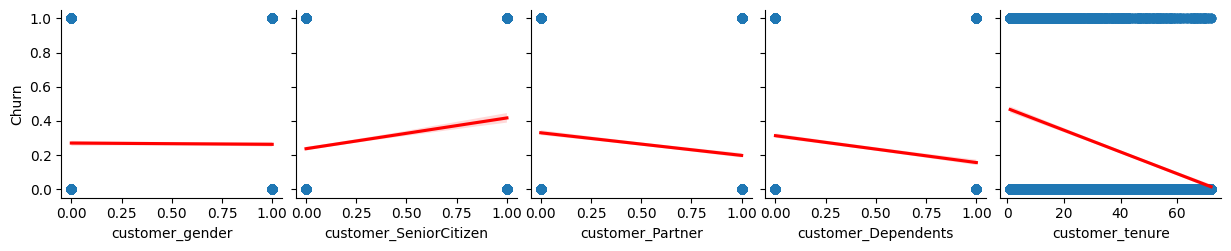

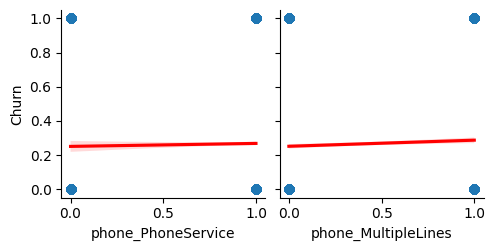

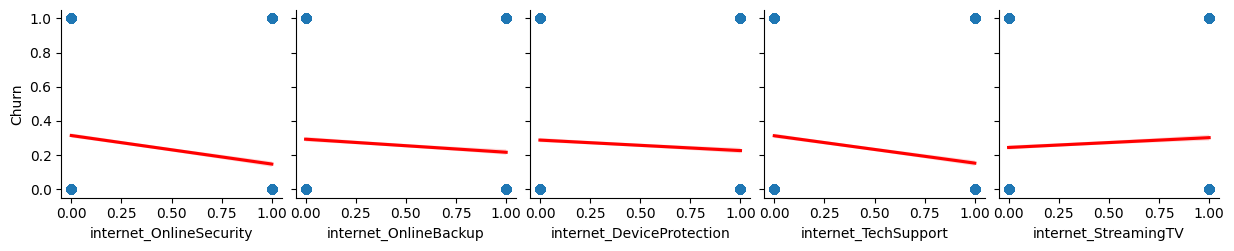

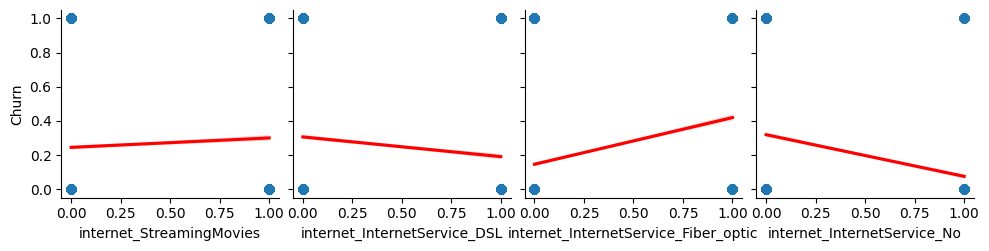

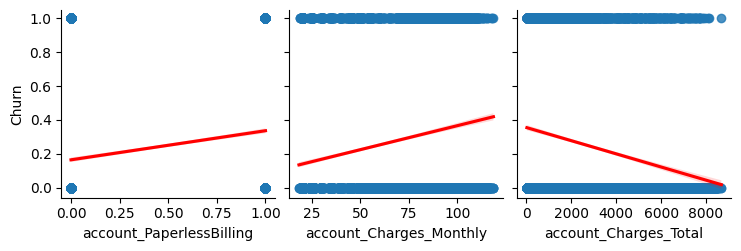

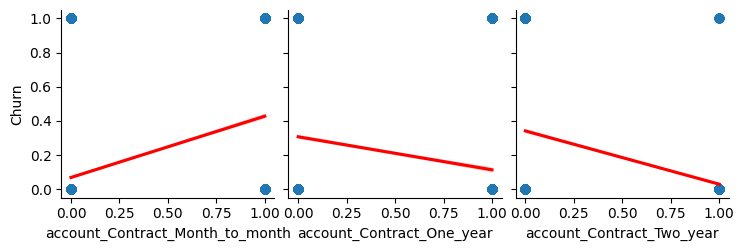

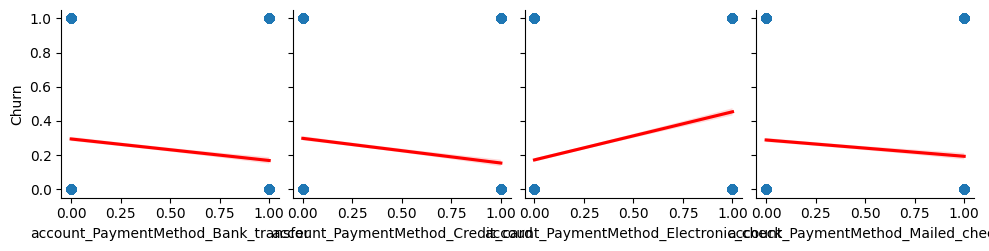

In [199]:
list_features = [['customer_gender','customer_SeniorCitizen','customer_Partner','customer_Dependents', 'customer_tenure'],
           ['phone_PhoneService', 'phone_MultipleLines'],
           ['internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV'],
           [ 'internet_StreamingMovies', 'internet_InternetService_DSL', 'internet_InternetService_Fiber_optic', 'internet_InternetService_No'],
           ['account_PaperlessBilling', 'account_Charges_Monthly', 'account_Charges_Total'],
           ['account_Contract_Month_to_month', 'account_Contract_One_year', 'account_Contract_Two_year'],
           ['account_PaymentMethod_Bank_transfer', 'account_PaymentMethod_Credit_card', 'account_PaymentMethod_Electronic_check', 'account_PaymentMethod_Mailed_check']]

for features in list_features:
  ax = sns.pairplot(data,
             y_vars='Churn',
             x_vars=features,
             kind= 'reg',
             plot_kws = {'line_kws' : {'color':'red'}})



## Main Insights:

- There are 7032 non-null rows 27 features.
  - Most of them are binary features
  - Some were converted to binary using one-hot encoding.
  - Target feature ('Churn') is highly unbalanced (75/25)
  - Feature 'customer_gender' is highly balanced (50/50)

-----

- Correlation results did not show a strong coorelation between the target feature and any of the independent variables.
- Multicollinearity where identified on the independent variables. However, these features were kept, since I intend to use tree-based models on the classifier.

-----

- Mean values for the non-binary features "account_Charges_Monthly", "account_Charges_Total" and "customer_tenure" seems to influence the Churn status. (Boxplot)

-----

- The linear regression of the pairplots confirms the correlation results, visually highlighting the most relevant features regarding Churn values.  